## Exploratory analysis of US indices

In [8]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import statsmodels.api as sm
import scipy.stats as scs
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

C:\Users\helen\anaconda3\envs\tfm_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'^GSPC'}>,
        <AxesSubplot:title={'center':'^DJI'}>],
       [<AxesSubplot:title={'center':'^IXIC'}>,
        <AxesSubplot:title={'center':'^RUT'}>]], dtype=object)

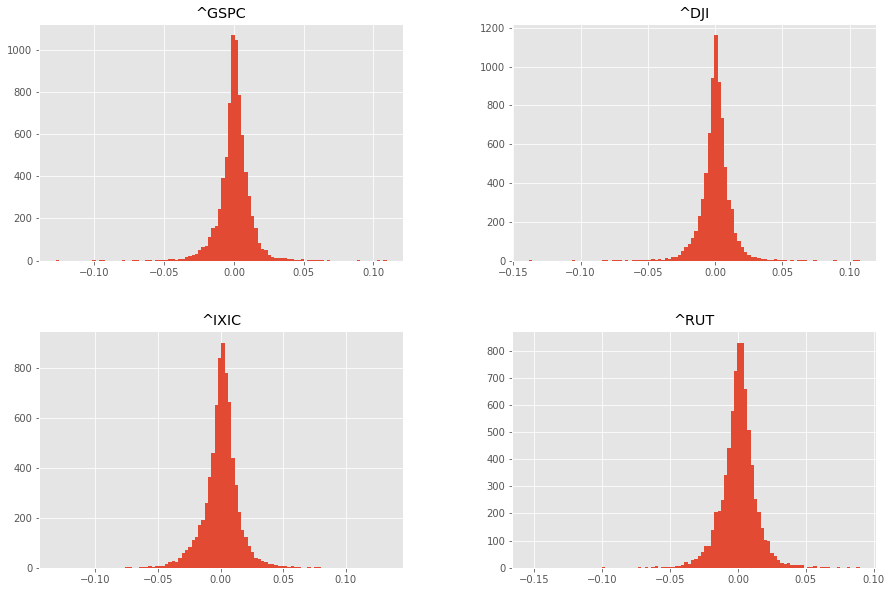

In [9]:
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT']
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='yahoo', start='1992-01-01', end='2021-12-31')['Adj Close']
data = data.dropna()
log_returns = np.log(data / data.shift(1))
log_returns.hist(bins=100, figsize=(15, 10))

In [10]:
def print_statistics(array):
    sta = scs.describe(array)
    print("%14s %15s" % ('statistic', 'value'))
    print( 30 * "-")
    print("%14s %15.5f" % ('size', sta[0]))
    print("%14s %15.5f" % ('min', sta[1][0]))
    print("%14s %15.5f" % ('max', sta[1][1]))
    print("%14s %15.5f" % ('mean', sta[2]))
    print("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print("%14s %15.5f" % ('skew', sta[4]))
    print("%14s %15.5f" % ('kurtosis', sta[5]))

In [11]:
for sym in symbols:
    print( "\nResults for symbol %s" % sym)
    print(30 * "-")
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)


Results for symbol ^GSPC
------------------------------
     statistic           value
------------------------------
          size      7557.00000
           min        -0.12765
           max         0.10957
          mean         0.00032
           std         0.01152
          skew        -0.42658
      kurtosis        11.61101

Results for symbol ^DJI
------------------------------
     statistic           value
------------------------------
          size      7557.00000
           min        -0.13842
           max         0.10764
          mean         0.00032
           std         0.01115
          skew        -0.42183
      kurtosis        13.38524

Results for symbol ^IXIC
------------------------------
     statistic           value
------------------------------
          size      7557.00000
           min        -0.13149
           max         0.13255
          mean         0.00043
           std         0.01479
          skew        -0.20816
      kurtosis         7

C:\Users\helen\anaconda3\envs\tfm_env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'S&P 500')

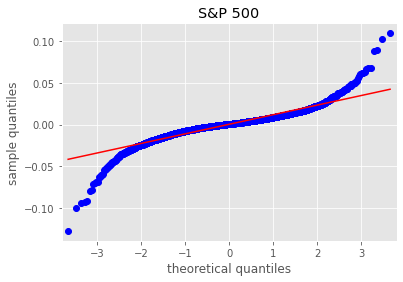

In [12]:
sm.qqplot(log_returns['^GSPC'].dropna(), line='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
plt.title("S&P 500")

In [13]:
def normality_tests(arr):
    print( "Skew of data set %14.3f" % scs.skew(arr))
    print( "Skew test p-value %14.3f" % scs.skewtest(arr)[1])
    print( "Kurt of data set %14.3f" % scs.kurtosis(arr))
    print( "Kurt test p-value %14.3f" % scs.kurtosistest(arr)[1])
    print( "Norm test p-value %14.3f" % scs.normaltest(arr)[1])

In [14]:
for sym in symbols:
    print( "\nResults for symbol %s" % sym)
    print( 32 * "-")
    log_data = np.array(log_returns[sym].dropna())
    normality_tests(log_data)


Results for symbol ^GSPC
--------------------------------
Skew of data set         -0.427
Skew test p-value          0.000
Kurt of data set         11.611
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ^DJI
--------------------------------
Skew of data set         -0.422
Skew test p-value          0.000
Kurt of data set         13.385
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ^IXIC
--------------------------------
Skew of data set         -0.208
Skew test p-value          0.000
Kurt of data set          7.038
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ^RUT
--------------------------------
Skew of data set         -0.604
Skew test p-value          0.000
Kurt of data set          8.914
Kurt test p-value          0.000
Norm test p-value          0.000


## Independent normally distributed variables with growing variance

In [15]:
import numpy as np
import gudhi as gd  
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy import integrate

The function below is taken from:
F. Chazal. Intro TDA with GUDHI Part2. https://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/Intro_TDA_with_GUDHI_Part_2.html. 2018.

In [16]:
def landscapes_approx(diag,p_dim,x_min,x_max,nb_nodes,nb_ld):
    """Compute a dicretization of the first nb_ld landscape of a 
    p_dim-dimensional persistence diagram on a regular grid on the 
    interval [x_min,x_max]. The output is a nb_ld x nb_nodes numpy
    array
    + diag: a persistence diagram (in the Gudhi format)
    + dim: the dimension in homology to consider
    """
    landscape = np.zeros((nb_ld,nb_nodes))
    diag_dim = []
    for pair in diag: #get persistence points for homology in dimension dim
        if (pair[0] == p_dim):
            diag_dim.append(pair[1])
    step = (x_max - x_min) / (nb_nodes - 1)
    for i in range(nb_nodes):
        x = x_min + i * step
        t = x / np.sqrt(2)
        event_list = []
        for pair in diag_dim:
            b = pair[0]
            d = pair[1]
            if b <= t <= d:
                if t >= (d + b) / 2:
                    event_list.append((d - t) * np.sqrt(2))
                else:
                    event_list.append((t - b) * np.sqrt(2))
        event_list.sort(reverse = True)
        event_list = np.asarray(event_list)
        for j in range(nb_ld):
            if(j < len(event_list)):
                landscape[j,i] = event_list[j]
    return landscape

Text(0.5, 1.0, 'L1 norm versus Standard Deviation')

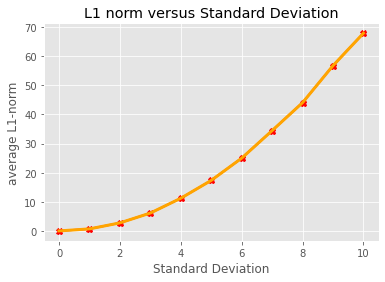

In [17]:
sdit = 10
MC = 400
n = 100
KK_max = 10
Norm1 = np.zeros( (sdit + 1, MC + 1) )

for i in range(1, sdit + 1):
    for s in range(1, MC + 1):
        #mean, standard deviation
        x1 = np.random.normal(0, i, n)
        x2 = np.random.normal(0, i, n)
        x3 = np.random.normal(0, i, n)
        x4 = np.random.normal(0, i, n)
        CoordMatrix = np.transpose([x1, x2, x3, x4])
        distances = pdist(CoordMatrix, metric = 'euclidean')
        dist_matrix = squareform(distances)
        max_dist = max(dist_matrix.flatten())
        rips_complex = gd.RipsComplex(points = CoordMatrix,
                                 max_edge_length = max_dist)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence()
        L = landscapes_approx(diag, 1, 0, max_dist, 1000, 10 )
        for j in range(0, KK_max):
            Norm1[i, s]=integrate.simps(L[j][0:1000], np.linspace(0, max_dist,1000)) + Norm1[i,s]
            
Norm1_mean = Norm1.mean(axis = 1, dtype = None, out = None)
plt.plot(Norm1_mean, color = "red", marker = "X", linewidth = 2)
plt.plot(Norm1_mean, color = "orange", linewidth = 3)
plt.ylabel("average L1-norm")
plt.xlabel("Standard Deviation")
plt.title("L1 norm versus Standard Deviation")

## Independent scaled Student’s t-distributed variables with growing scaling parameter

Text(0.5, 1.0, 'L1-norm versus scaling factor')

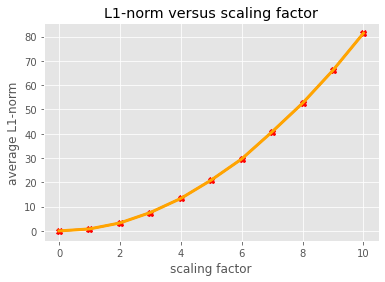

In [18]:
sdit = 10
MC = 400
n = 100
KK_max = 10
Norm1 = np.zeros((sdit + 1, MC + 1))

for i in range(1,sdit + 1):
    for s in range(1, MC + 1):
        #degrees of freedom and size
        x1 = i*random.standard_t(4, size = n)
        x2 = i*random.standard_t(4, size = n)
        x3 = i*random.standard_t(4, size = n)
        x4 = i*random.standard_t(4, size = n)
        CoordMatrix = np.transpose([x1 ,x2, x3, x4])
        distances = pdist(CoordMatrix, metric = 'euclidean')
        dist_matrix = squareform(distances)
        max_dist = max(dist_matrix.flatten())
        rips_complex = gd.RipsComplex(points = CoordMatrix,
                                 max_edge_length = max_dist)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence()
        L = landscapes_approx(diag, 1, 0, max_dist, 1000, 10)
        for j in range(0, KK_max):
            Norm1[i, s]=integrate.simps(L[j][0 : 1000], np.linspace(0, max_dist, 1000))+Norm1[i, s]

Norm1_mean = Norm1.mean(axis = 1, dtype = None, out = None)
plt.plot(Norm1_mean, color = "red", marker = "X", linewidth = 2) 
plt.plot(Norm1_mean, color = "orange", linewidth = 3)
plt.ylabel("average L1-norm")
plt.xlabel("scaling factor")
plt.title("L1-norm versus scaling factor")

## Correlated normally distributed random variables

Test 1

Text(0.5, 1.0, 'L1-norm versus Correlation Coefficient')

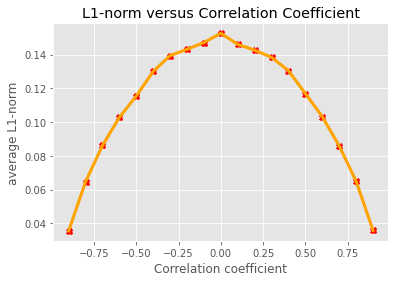

In [19]:
MC = 400
n = 100
KK_max = 10
value_range = np.arange(-.9, 1, 0.1)
Norm1 = np.zeros((len(value_range) +1, MC + 1))
sigma = 1
i = 1
for rho in value_range: #correlation
    for s in range(1, MC + 1):
        #mean, standard deviation
        x1 = np.random.normal(0, sigma, n)
        x22 = np.random.normal(0, sigma, n)#to initialize x2
        x2 = rho * x1 + np.sqrt(1 - rho**2) * x22
        CoordMatrix = np.transpose([x1, x2])
        distances = pdist(CoordMatrix, metric = 'euclidean')
        dist_matrix = squareform(distances)
        max_dist = max(dist_matrix.flatten())
        rips_complex = gd.RipsComplex(points = CoordMatrix,
                                 max_edge_length = max_dist)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence()
        L=landscapes_approx(diag, 1, 0, max_dist, 1000, 10)
        for j in range(0, KK_max):
            Norm1[i, s]=integrate.simps(L[j][0 : 1000], np.linspace(0, max_dist, 1000))+Norm1[i, s]
    i=i+1
    
Norm1_mean = Norm1.mean(axis = 1, dtype = None, out = None)
plt.plot(value_range, Norm1_mean[1 : ], color = "red", marker = "X", linewidth = 2) 
plt.plot(value_range, Norm1_mean[1 : ],color = "orange", linewidth = 3)
plt.ylabel("average L1-norm")
plt.xlabel("Correlation coefficient")
plt.title("L1-norm versus Correlation Coefficient")

Test 2

Text(0.5, 1.0, 'L1-norm versus Correlation Coefficient')

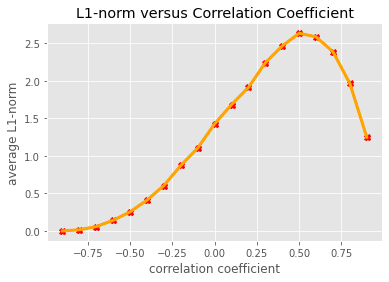

In [20]:
MC = 400
n = 100
KK_max = 10
value_range = np.arange(-.9, 1, 0.1)
Norm1 = np.zeros((len(value_range) + 1, MC + 1))
sigma = np.arange(0.2, 6, 0.32)
i=1

for rho in value_range: #correlation
    for s in range(1, MC + 1):
        #mean, standard deviation
        x1=np.random.normal(0, 1, n)
        x2=np.random.normal(0, 1, n)
        x3=rho * x1 + np.sqrt(1 - rho**2) * x2
        y1 = sigma[i - 1] * x1
        y2 = sigma[i - 1] * x3
        CoordMatrix = np.transpose([y1, y2])
        distances = pdist(CoordMatrix, metric='euclidean')
        dist_matrix = squareform(distances)
        max_dist = max(dist_matrix.flatten())
        rips_complex = gd.RipsComplex(points = CoordMatrix,
                                 max_edge_length = max_dist)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence()
        L = landscapes_approx(diag, 1, 0, max_dist, 1000, 10)
        for j in range(0, KK_max):
            Norm1[i, s]=integrate.simps(L[j][0 : 1000],np.linspace(0, max_dist, 1000))+Norm1[i, s]
    i=i+1
    
Norm1_mean = Norm1.mean(axis=1, dtype=None, out=None)
plt.plot(value_range, Norm1_mean[1 : ], color = "red", marker = "X", linewidth = 2)
plt.plot(value_range, Norm1_mean[1 : ],color = "orange", linewidth = 3)
plt.ylabel("average L1-norm")
plt.xlabel("correlation coefficient")
plt.title("L1-norm versus Correlation Coefficient")

## L^1-norm of the persistence landscape

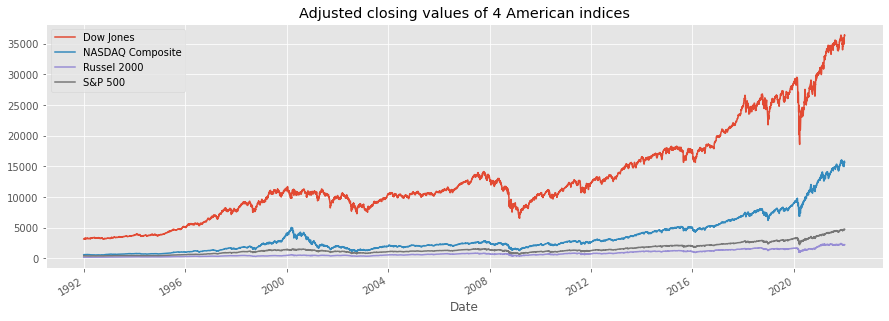

In [22]:
DIJA = web.DataReader(name = '^DJI', data_source = 'yahoo',
start = '1992-01-01', end = '2021-12-31')
NASDAQ = web.DataReader(name = '^IXIC', data_source = 'yahoo',
start = '1992-01-01', end = '2021-12-31')
GSPC = web.DataReader(name = '^GSPC', data_source = 'yahoo',
start = '1992-01-01', end = '2021-12-31')
RUT = web.DataReader(name = '^RUT', data_source = 'yahoo',
start = '1992-01-01', end = '2021-12-31')
#plot of the adjusted closing prices
style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)
DIJA['Adj Close'].plot(label = 'Dow Jones')
NASDAQ['Adj Close'].plot(label = 'NASDAQ Composite')
RUT['Adj Close'].plot(label = "Russel 2000")
GSPC['Adj Close'].plot(label = "S&P 500")
plt.legend()
plt.title('Adjusted closing values of 4 American indices');

<AxesSubplot:xlabel='Date'>

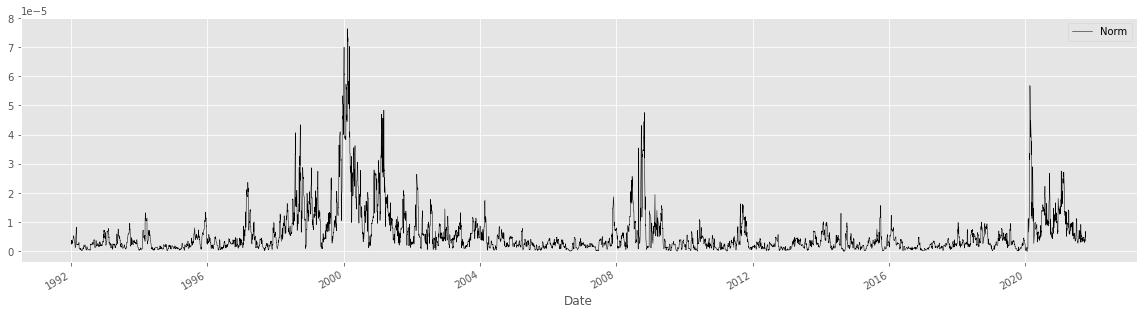

In [23]:
DIJA['Return'] = np.log(DIJA['Adj Close'] / DIJA['Adj Close'].shift(1))
NASDAQ['Return'] = np.log(NASDAQ['Adj Close'] / NASDAQ['Adj Close'].shift(1))
RUT['Return'] = np.log(RUT['Adj Close'] / RUT['Adj Close'].shift(1))
GSPC['Return'] = np.log(GSPC['Adj Close'] / GSPC['Adj Close'].shift(1))

price_series = (
    DIJA[['Return']]
    .join(NASDAQ[['Return']], on = "Date", lsuffix = "_DIJA", rsuffix = "_NASDAQ")
    .join(RUT[['Return']], on = "Date")
    .join(GSPC[['Return']], on = 'Date', lsuffix = '_RUT', rsuffix = '_GSPC')
    [1:]
)
dim = price_series.shape
Norm1 = np.zeros( (dim[0],1) )
w = 50
KK_max = 10 #number of landscapes we compute
for i in range(dim[0] - w): 
    j = i + w 
    CoordMatrix = price_series[i : j] 
    distances = pdist(CoordMatrix, metric = 'euclidean')
    dist_matrix = squareform(distances)
    max_dist = max(dist_matrix.flatten())
    rips_complex = gd.RipsComplex(distance_matrix = dist_matrix,
                                 max_edge_length = max_dist)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
    diag = simplex_tree.persistence()
    L = landscapes_approx(diag, 1, 0, max_dist, 1000, KK_max )
    for j in range(0, KK_max):
        Norm1[i, 0] = integrate.simps(L[j][0 : 1000], np.linspace(0, max_dist, 1000))+Norm1[i, 0]
price_series['Norm'] = Norm1
plt.rcParams["figure.figsize"] = (20, 5)
price_series[["Norm"]][0 : 7500].plot(color = 'black', linewidth = .5)

## Rolling variance

Text(0.5, 1.0, 'Normalized L^1 norm and variances for the US stock indices')

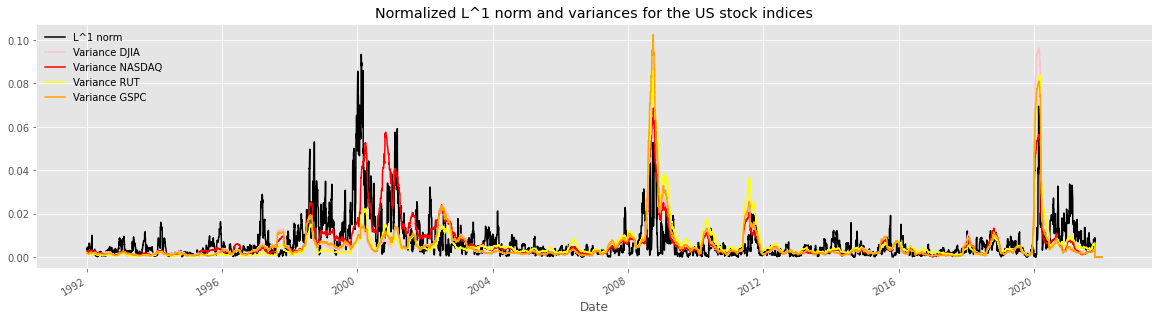

In [24]:
Var_tot = np.zeros((dim[0], 4))
for i in range(dim[0] - w):
    j = i + w 
    Var_tot[i] = np.var(price_series[["Return_DIJA", "Return_NASDAQ", "Return_RUT", "Return_GSPC"]][i : j])
price_series["Var_djia"] = Var_tot[:, 0] / np.linalg.norm(Var_tot[:, 0])
price_series["Var_nasdaq"] = Var_tot[:,1] / np.linalg.norm(Var_tot[:, 1])
price_series["Var_rut"] = Var_tot[:,2] / np.linalg.norm(Var_tot[:, 2])
price_series["Var_gspc"] = Var_tot[:,3] / np.linalg.norm(Var_tot[:, 3])
price_series["Norm_normalized"] = price_series["Norm"] / np.linalg.norm(price_series["Norm"])
price_series[["Norm_normalized", "Var_djia", "Var_nasdaq", "Var_rut", "Var_gspc" ]].plot(color=["black", "pink", "red", "yellow", "orange"])
plt.legend(["L^1 norm", "Variance DJIA", "Variance NASDAQ", "Variance RUT", "Variance GSPC"],
          loc = 'upper left', frameon = False) 
plt.title("Normalized L^1 norm and variances for the US stock indices")

## Persistence barcode, persistence diagram and persistence landscape

Rips complex is of dimension 2 - 20875 simplices - 50 vertices.


Text(0.5, 1.0, 'Persistence diagram January 10, 2000')

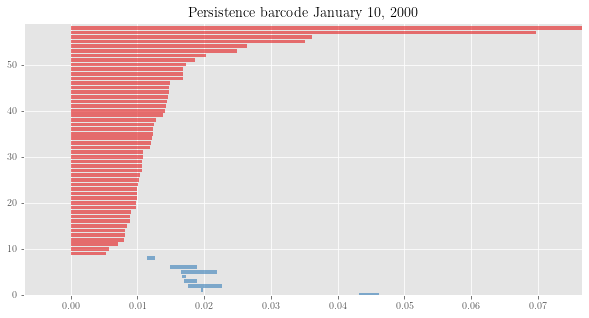

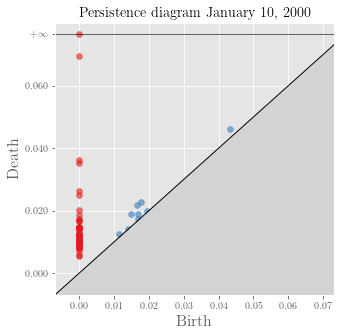

In [29]:
day = pd.to_datetime('2000-01-10')
CoordMatrix = price_series.loc[day - pd.Timedelta("73 days") : day]
distances = pdist(CoordMatrix, metric = 'euclidean')
dist_matrix = squareform(distances)
max_dist = max(dist_matrix.flatten())
rips_complex = gd.RipsComplex(distance_matrix = dist_matrix,
                                 max_edge_length = max_dist)
simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
diag = simplex_tree.persistence()
L=landscapes_approx(diag, 1, 0, max_dist, 1000, KK_max )
result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
print(result_str)
gd.plot_persistence_barcode(diag)  
plt.rcParams["figure.figsize"] = (5, 5)
plt.title("Persistence barcode January 10, 2000")
gd.plot_persistence_diagram(diag)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title("Persistence diagram January 10, 2000")

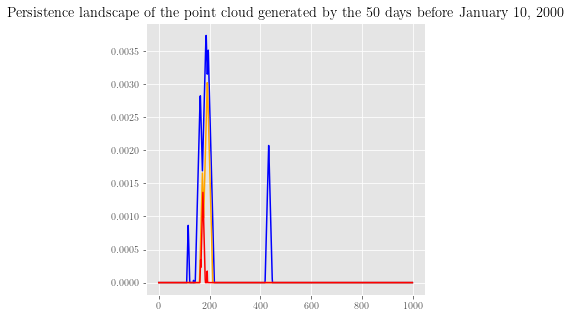

In [30]:
plt.plot(L[0], color = "blue") #first landscape
plt.plot(L[1], color = "orange") #second landscape
plt.plot(L[2], color = "red") #third landscape
plt.title("Persistence landscape of the point cloud generated by the 50 days before January 10, 2000")
plt.rcParams["figure.figsize"] = (10, 5)

## Early warning system

Text(0.5, 1.0, 'Critical dates for the Dotcom crash')

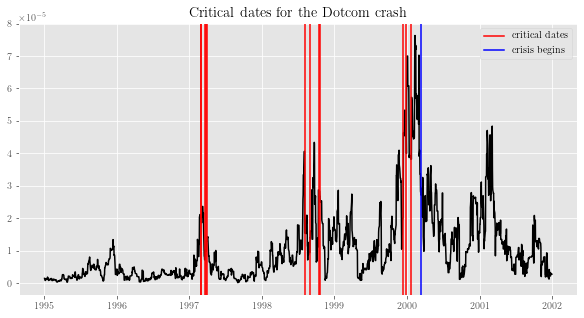

In [35]:
Norm2000 = price_series["Norm"][pd.Timestamp("1995-01-01") : pd.Timestamp("2000-03-10")]
dim_2000 = len(Norm2000)
n = 250
b1 = 3
alpha = 1.4
N = np.zeros(dim_2000)
B = np.zeros(dim_2000) 
for j in range(n, len(N)): 
    N[j] = Norm2000[j] 
    B[j] = np.mean(Norm2000[j-n:j]) 
l=[]
for j in range(n + 1, len(N) - w - 1):
    if N[j] / N[j-1] >= alpha and N[j] / B[j] >= b1:
        l.append(j)
#shift w/2 days to get the centered day
for i in range(len(l)):
    l[i] = l[i] + 25
Norm2000.iloc[l]

plt.plot(price_series["Norm"][pd.Timestamp("1995-01-01") : pd.Timestamp("2002-01-01")], color = "black")
plt.axvline(pd.Timestamp(Norm2000.index.values[l[0]]), color = "red", label = "critical dates")
for x in l:
    plt.axvline(pd.Timestamp(Norm2000.index.values[x]), color = "red")
plt.axvline(pd.Timestamp("2000-03-10"), color = "blue", label = "crisis begins")
plt.legend()
plt.title("Critical dates for the Dotcom crash")

## Correlation among pairs of indices

Average correlation coefficient    0.98578
dtype: float64

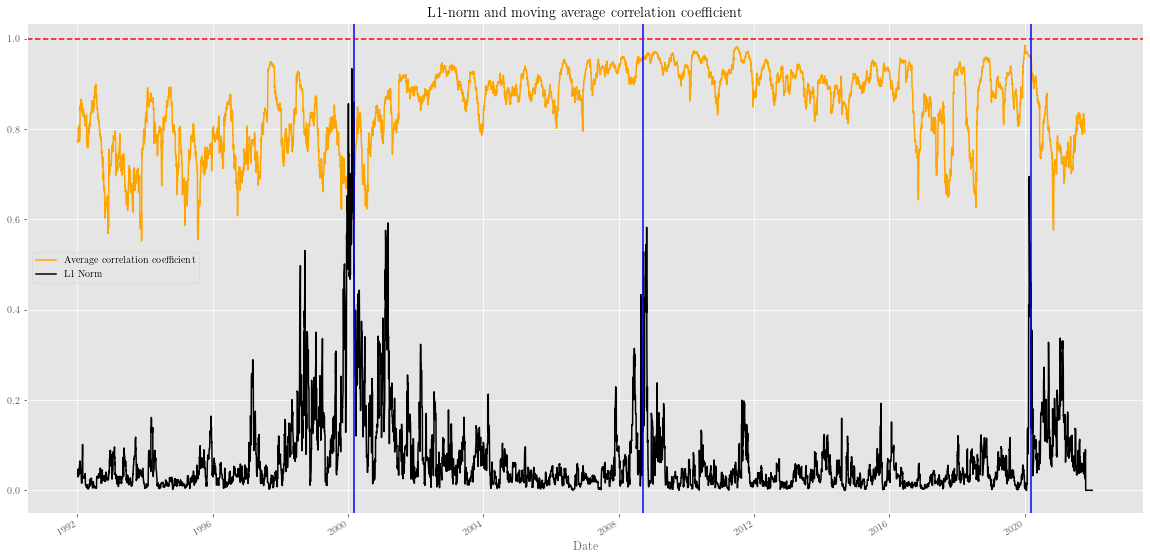

In [37]:
#each series corresponds to the correlation of a pair of indices 
Series1 = np.zeros(dim[0])
Series2 = np.zeros(dim[0])
Series3 = np.zeros(dim[0])
Series4 = np.zeros(dim[0])
Series5 = np.zeros(dim[0])
Series6 = np.zeros(dim[0])
for i in range(dim[0] - w):
    j = i + w
    Series1[i] = price_series[["Return_DIJA", "Return_NASDAQ"]][i : j].corr()["Return_DIJA"][1]
    Series2[i] = price_series[["Return_DIJA", "Return_RUT"]][i : j].corr()["Return_DIJA"][1]
    Series3[i] = price_series[["Return_DIJA", "Return_GSPC"]][i : j].corr()["Return_DIJA"][1]
    Series4[i] = price_series[["Return_RUT", "Return_NASDAQ"]][i : j].corr()["Return_RUT"][1]
    Series5[i] = price_series[["Return_GSPC", "Return_RUT"]][i : j].corr()["Return_GSPC"][1]
    Series6[i] = price_series[["Return_NASDAQ", "Return_GSPC"]][i : j].corr()["Return_NASDAQ"][1]
Serie_tot = (Series1+Series2+Series3+Series4+Series5+Series6) / 6 #average corr coeff
price_series['Average correlation coefficient'] = Serie_tot
plt.rcParams["figure.figsize"] = (20, 10)
price_series[['Average correlation coefficient']][0 : 7500].plot(color = 'orange', label = "Moving averange correlation coefficient")
plt.plot(price_series[["Norm_normalized"]] * 10, color = "black", label = "L1 Norm")
plt.axvline(pd.Timestamp("2000-03-10"), color = "blue")
plt.axvline(pd.Timestamp("2008-09-15"), color = "blue")
plt.axhline(1, color = 'r', linestyle = 'dashed')
plt.axvline(pd.Timestamp("2020-03-13"), color="blue")
plt.legend()
plt.title("L1-norm and moving average correlation coefficient")
np.max(price_series[['Average correlation coefficient']])